In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
!pip install pyspark

In [43]:
import os
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [44]:
myDf = spark\
        .read.format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true')\
        .load(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/서울시 지하철 호선별 역별 유_무임 승하차 인원 정보.csv'))

In [41]:
myDf.printSchema()

root
 |-- 사용월: integer (nullable = true)
 |-- 호선명: string (nullable = true)
 |-- 지하철역: string (nullable = true)
 |-- 유임승차인원: integer (nullable = true)
 |-- 무임승차인원: integer (nullable = true)
 |-- 유임하차인원: integer (nullable = true)
 |-- 무임하차인원: integer (nullable = true)
 |-- 작업일자: integer (nullable = true)



In [45]:
myDf.show(3)

+------+------+----------------------+------------+------------+------------+------------+--------+
|사용월|호선명|              지하철역|유임승차인원|무임승차인원|유임하차인원|무임하차인원|작업일자|
+------+------+----------------------+------------+------------+------------+------------+--------+
|202109| 1호선|청량리(서울시립대입구)|      273889|      233762|      271624|      239320|20211003|
|202109| 1호선|                제기동|      197782|      244303|      192380|      264653|20211003|
|202109| 1호선|               종로5가|      298511|      218858|      303620|      211256|20211003|
+------+------+----------------------+------------+------------+------------+------------+--------+
only showing top 3 rows



##9-1: 문제 설정
* 1.무임승차자와 무임하차자가 각각 가장 많은 호선은 어디인가?

In [56]:
sum_line=myDf.groupBy('호선명').agg({"무임승차인원":"sum"}).orderBy("호선명")

In [57]:
sum_line.show()

+--------------+-----------------+
|        호선명|sum(무임승차인원)|
+--------------+-----------------+
|         1호선|        240458093|
|         2호선|        859722081|
|         3호선|        371776881|
|         4호선|        388767895|
|         5호선|        402967996|
|         6호선|        232685570|
|         7호선|        448931809|
|         8호선|        123031651|
|         9호선|        160132280|
|  9호선2~3단계|         14685373|
|    9호선2단계|          8201248|
|        경강선|          8642265|
|        경부선|        229664731|
|        경원선|        157775411|
|        경의선|         56734301|
|        경인선|        185471707|
|        경춘선|         28161811|
|공항철도 1호선|         32211437|
|        과천선|         54453191|
|        분당선|        189934168|
+--------------+-----------------+
only showing top 20 rows



In [90]:
sum_out=myDf.groupBy('호선명').agg({"무임하차인원":"sum"}).orderBy("호선명")

In [59]:
sum_out.show()

+--------------+-----------------+
|        호선명|sum(무임하차인원)|
+--------------+-----------------+
|         1호선|        191672050|
|         2호선|        458323025|
|         3호선|        243351024|
|         4호선|        250550951|
|         5호선|        272467701|
|         6호선|        154526048|
|         7호선|        278437332|
|         8호선|         86298022|
|         9호선|         95449091|
|  9호선2~3단계|         14238299|
|    9호선2단계|          4536177|
|        경강선|          8420698|
|        경부선|        172464673|
|        경원선|        138902924|
|        경의선|         48678602|
|        경인선|        150861716|
|        경춘선|         24349588|
|공항철도 1호선|         20953644|
|        과천선|         42597695|
|        분당선|        153989418|
+--------------+-----------------+
only showing top 20 rows



In [60]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [61]:
line=sum_line.rdd.map(lambda fields:fields[0]).collect()
sum_people=sum_line.rdd.map(lambda fields:fields[1]).collect()
lineout=sum_out.rdd.map(lambda fields:fields[0]).collect()
sum_out_people=sum_out.rdd.map(lambda fields:fields[1]).collect()

In [62]:
#길이 옆으로 늘리기
plt.rcParams["figure.figsize"] = (30,5)

#격자
plt.rcParams['axes.grid'] = True

#두께
plt.rcParams['lines.linewidth'] = 2

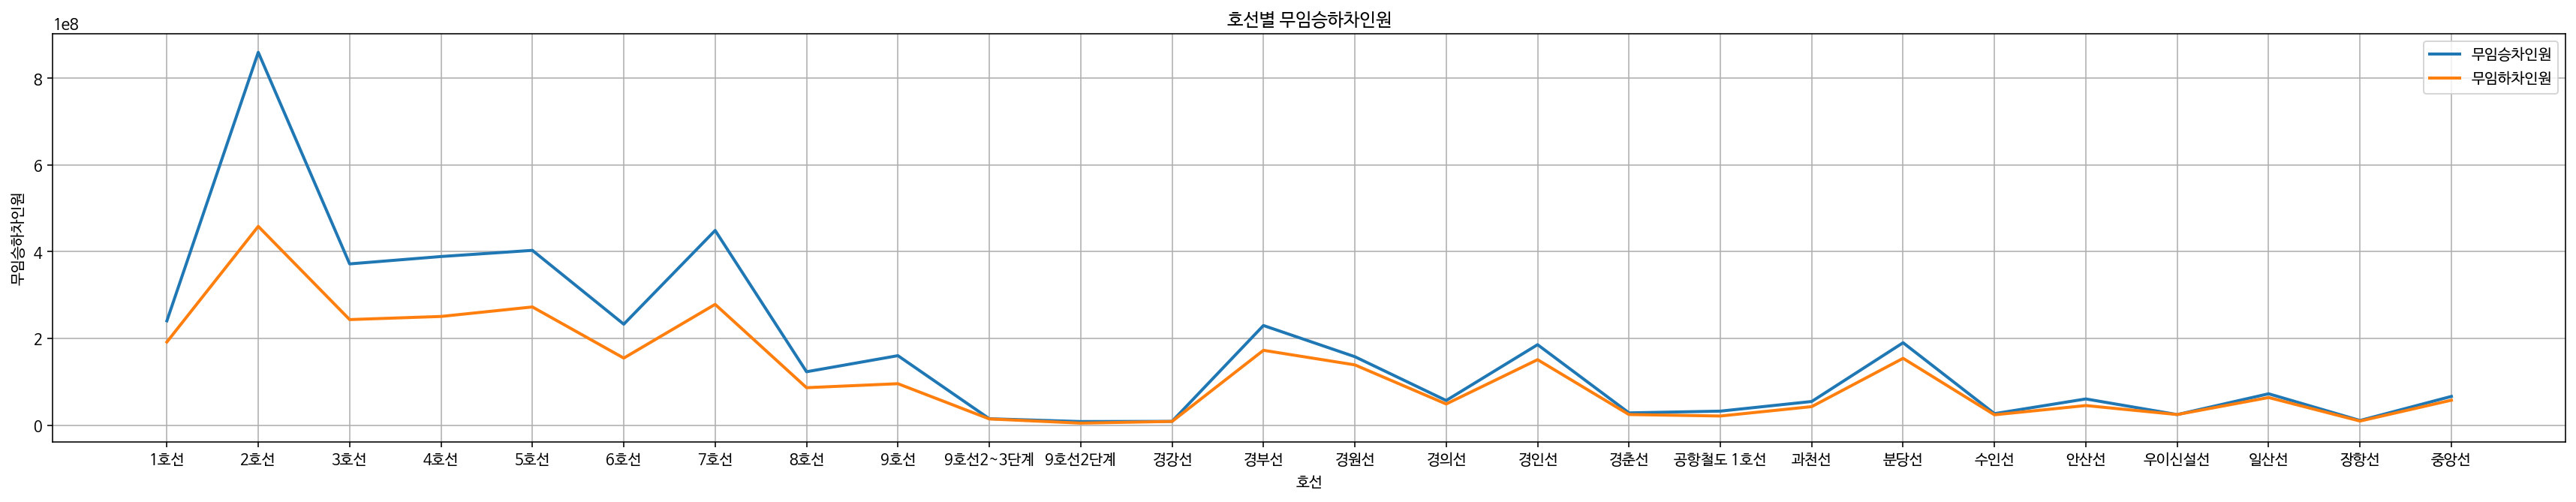

In [72]:
from matplotlib import rc, font_manager
rc('font',family="NanumBarunGothic")
plt.plot(np.array(line), np.array(sum_people),label='무임승차인원')
plt.plot(np.array(lineout), np.array(sum_out_people),label='무임하차인원')

#title
plt.title("호선별 무임승하차인원")

#x,y label
plt.xlabel("호선")
plt.ylabel("무임승하차인원")
plt.legend()

In [69]:
# #코렙에서 한글폰트 쓰는법
# !apt -qq -y install fonts-nanum > /dev/null
 
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
 
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=10)
# fm._rebuild()
 
# # 그래프에 retina display 적용
# %config InlineBackend.figure_format = 'retina'
 
# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic') 
# #http://growthj.link/python-matplotlib-%ED%95%9C%EA%B8%80-%ED%8F%B0%ED%8A%B8-%EC%84%A4%EC%B9%98%ED%95%98%EA%B8%B0%EA%B5%AC%EA%B8%80-colab/

2.호선별 무임승차인원 하차인원의 상관관계

In [93]:
import pandas as pd

In [95]:
sum_line=sum_line.toPandas()
sum_out=sum_out.toPandas()

In [97]:
Suminout=pd.merge(sum_line,sum_out)
print(Suminout)

         호선명  sum(무임승차인원)  sum(무임하차인원)
0        1호선    240458093    191672050
1        2호선    859722081    458323025
2        3호선    371776881    243351024
3        4호선    388767895    250550951
4        5호선    402967996    272467701
5        6호선    232685570    154526048
6        7호선    448931809    278437332
7        8호선    123031651     86298022
8        9호선    160132280     95449091
9   9호선2~3단계     14685373     14238299
10    9호선2단계      8201248      4536177
11       경강선      8642265      8420698
12       경부선    229664731    172464673
13       경원선    157775411    138902924
14       경의선     56734301     48678602
15       경인선    185471707    150861716
16       경춘선     28161811     24349588
17  공항철도 1호선     32211437     20953644
18       과천선     54453191     42597695
19       분당선    189934168    153989418
20       수인선     26406414     23712645
21       안산선     60327438     45089859
22     우이신설선     24287340     24325417
23       일산선     72223193     63592602
24       장항선     10613566

In [98]:
Sum_in_out = spark.createDataFrame(Suminout)

In [99]:
Sum_in_out.printSchema()

root
 |-- 호선명: string (nullable = true)
 |-- sum(무임승차인원): long (nullable = true)
 |-- sum(무임하차인원): long (nullable = true)



In [103]:

from pyspark.sql.window import Window
import sys

byAll = Window.rowsBetween(-sys.maxsize, sys.maxsize)

In [105]:
from pyspark.sql import functions as F

Sum_in_out = Sum_in_out.withColumn("mean_in", F.avg(Sum_in_out['sum(무임승차인원)']).over(byAll))
Sum_in_out = Sum_in_out.withColumn("stddev_in", F.stddev(Sum_in_out['sum(무임승차인원)']).over(byAll))
Sum_in_out = Sum_in_out.withColumn("zscore_in", (F.col('sum(무임승차인원)')-F.col('mean_in'))/F.col('stddev_in'))
Sum_in_out.show(3)

+------+-----------------+-----------------+--------------------+-------------------+-------------------+
|호선명|sum(무임승차인원)|sum(무임하차인원)|             mean_in|          stddev_in|          zscore_in|
+------+-----------------+-----------------+--------------------+-------------------+-------------------+
| 1호선|        240458093|        191672050|1.7132387123076922E8|1.952551448491894E8|0.35407119142816174|
| 2호선|        859722081|        458323025|1.7132387123076922E8|1.952551448491894E8| 3.5256341660084494|
| 3호선|        371776881|        243351024|1.7132387123076922E8|1.952551448491894E8|  1.026620885836612|
+------+-----------------+-----------------+--------------------+-------------------+-------------------+
only showing top 3 rows



In [106]:
from pyspark.sql import functions as F

Sum_in_out = Sum_in_out.withColumn("mean_out", F.avg(Sum_in_out['sum(무임하차인원)']).over(byAll))
Sum_in_out = Sum_in_out.withColumn("stddev_out", F.stddev(Sum_in_out['sum(무임하차인원)']).over(byAll))
Sum_in_out = Sum_in_out.withColumn("zscore_out", (F.col('sum(무임하차인원)')-F.col('mean_out'))/F.col('stddev_out'))
Sum_in_out.show(3)

+------+-----------------+-----------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+
|호선명|sum(무임승차인원)|sum(무임하차인원)|             mean_in|          stddev_in|          zscore_in|           mean_out|         stddev_out|        zscore_out|
+------+-----------------+-----------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+
| 1호선|        240458093|        191672050|1.7132387123076922E8|1.952551448491894E8|0.35407119142816174|1.167128426923077E8|1.128651599253762E8|0.6641483284766847|
| 2호선|        859722081|        458323025|1.7132387123076922E8|1.952551448491894E8| 3.5256341660084494|1.167128426923077E8|1.128651599253762E8|3.0267106566238593|
| 3호선|        371776881|        243351024|1.7132387123076922E8|1.952551448491894E8|  1.026620885836612|1.167128426923077E8|1.128651599253762E8| 1.122030761232452|
+------+-----------------+-----

In [107]:
Sum_in_out.stat.corr('zscore_in', 'zscore_out')

0.9850572771193759